In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip

--2021-09-19 21:56:19--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  24.8MB/s    in 8.7s    

2021-09-19 21:56:29 (22.8 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]



In [ ]:
!unzip Audio_Speech_Actors_01-24.zip -d Audio_Speech_Actors_01-24

Archive:  Audio_Speech_Actors_01-24.zip
   creating: Audio_Speech_Actors_01-24/Actor_01/
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-01-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-01-02-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-01-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-01-01-02-02-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-01-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-02-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-01-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-02-02-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-01-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-01-02-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-02-01-01.wav  
  inflating: Audio_Speech_Actors_01-24/Actor_01/03-01-02-02-02-02-01.wav  
  inflating

# CODE START

In [ ]:
import os
import random
import sys


## Package
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)


## Keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [ ]:
dir_list = os.listdir('/content/Audio_Speech_Actors_01-24')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
# Acoording to the given file identifiers we can make the following inferences
# Create DataFrame for Data intel
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('/content/Audio_Speech_Actors_01-24/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = '/content/Audio_Speech_Actors_01-24/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [ ]:
print (len(data_df))
data_df.head(25)

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5
1,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,5
2,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6
3,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,1,6
4,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6
5,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8
6,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,7
7,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,2
8,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,7
9,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,0,6


In [ ]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [ ]:
data_df['label'] = label8_list

In [ ]:
print (data_df.label.value_counts().keys())

Index(['male_surprised', 'male_happy', 'female_disgust', 'female_surprised',
       'male_fearful', 'female_happy', 'male_angry', 'male_sad',
       'female_fearful', 'male_calm', 'female_sad', 'female_calm',
       'male_disgust', 'female_angry', 'male_neutral', 'female_neutral'],
      dtype='object')


In [ ]:
# Male Data Set

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "female_disgust"]
data2_df = data2_df[data2_df.label != "female_surprised"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_neutral"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head(50)

600


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5,male_angry
1,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,5,male_angry
2,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6,male_fearful
3,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,1,6,male_fearful
4,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6,male_fearful
5,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8,male_surprised
6,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,7,male_disgust
7,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,2,male_calm
8,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,7,male_disgust
9,/content/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,0,6,male_fearful


In [ ]:
print (len(data3_df))
data3_df.head(80)

120


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,/content/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,1,0,0,7,male_disgust
1,/content/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,1,0,0,3,male_happy
2,/content/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,1,0,0,6,male_fearful
3,/content/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,0,0,4,male_sad
4,/content/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,0,0,8,male_surprised
...,...,...,...,...,...,...,...,...,...
75,/content/Audio_Speech_Actors_01-24/Actor_23/03...,1,23,male,1,0,1,7,male_disgust
76,/content/Audio_Speech_Actors_01-24/Actor_23/03...,1,23,male,1,0,1,6,male_fearful
77,/content/Audio_Speech_Actors_01-24/Actor_23/03...,1,23,male,0,1,0,6,male_fearful
78,/content/Audio_Speech_Actors_01-24/Actor_23/03...,1,23,male,1,0,0,5,male_angry


In [ ]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 600/600 [00:46<00:00, 12.97it/s]


In [ ]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [ ]:
df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.998737,-55.762722,-55.630779,-56.157837,-56.156944,-56.155884,-56.061825,-54.492226,-54.634743,-55.506390,-56.036907,-55.510700,-55.296021,-55.582066,-55.227253,-55.727543,-55.387268,-54.642632,-52.247322,-51.427738,-44.798054,-35.406475,...,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.954964,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336
1,-55.507362,-55.729572,-55.716793,-55.835808,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-52.321838,-48.607483,-47.562637,-48.706680,-50.651569,-47.451721,-48.451572,-50.801384,-53.045284,-54.572227,-51.542358,-51.286385,-55.301247,-55.732063,-52.488266,...,-53.749947,-55.165913,-53.954857,-53.909660,-53.311016,-53.701260,-54.495907,-55.171837,-55.835918,-55.642986,-55.767822,-55.599236,-55.932133,-55.932133,-55.234035,-55.424355,-55.932133,-55.932133,-54.555664,-54.257195,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133
2,-43.197392,-44.238602,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,-44.350521,-44.399761,-44.158318,-43.829643,-44.093845,-44.558105,-44.768948,-44.720158,-45.150978,-44.953712,-44.477928,-44.188469,-44.541679,-44.076675,-44.566505,-44.196739,-42.775211,-39.651863,-39.646610,-38.510967,-37.156334,-35.155792,-33.137333,-28.639688,-24.096514,-20.208851,-16.848576,-15.777185,-16.839069,-20.438622,...,-23.869072,-27.399906,-27.543013,-27.825289,-26.374758,-26.433462,-26.809801,-29.282017,-26.990065,-26.587029,-28.645277,-30.838076,-32.098305,-32.290539,-33.849228,-35.313438,-37.186554,-38.559994,-37.166969,-38.283073,-39.934586,-38.492546,-37.710320,-38.639431,-38.270096,-39.254551,-40.667336,-39.336838,-38.503994,-37.974186,-40.030666,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612
3,-35.372726,-36.900326,-38.971123,-38.443581,-37.651356,-38.045132,-38.624809,-42.541157,-43.463234,-43.102680,-44.003311,-43.842228,-43.057720,-41.091534,-42.039639,-42.282372,-42.852482,-43.261154,-42.841877,-44.633179,-46.468849,-46.622623,-45.426495,-42.309258,-41.364555,-37.966160,-37.641335,-39.257729,-39.193436,-37.701748,-36.158943,-33.359802,-30.561909,-30.390989,-33.017899,-36.560017,-35.270130,-30.044569,-26.521118,-29.338322,...,-38.226742,-39.272171,-40.222435,-38.710598,-38.585148,-41.496273,-42.743504,-45.237206,-44.827621,-44.520222,-46.004047,-47.705627,-46.887859,-47.993221,-47.891781,-46.704670,-46.869095,-46.338326,-46.725822,-46.327068,-46.676285,-48.064487,-48.148048,-45.675552,-45.190086,-46.911221,-46.096066,-46.833645,-47.934441,-45.739204,-44.709751,-44.527992,-45.828773,-47.234535,-47.322300,-46.968773,-47.675339,-48.195766,-47.573978,-48.545269
4,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63

In [ ]:
newdf = pd.concat([df3,labels], axis=1)

In [ ]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

600

In [ ]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.998737,-55.762722,-55.630779,-56.157837,-56.156944,-56.155884,-56.061825,-54.492226,-54.634743,-55.506390,-56.036907,-55.510700,-55.296021,-55.582066,-55.227253,-55.727543,-55.387268,-54.642632,-52.247322,-51.427738,-44.798054,-35.406475,...,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.954964,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,male_angry
1,-55.507362,-55.729572,-55.716793,-55.835808,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-52.321838,-48.607483,-47.562637,-48.706680,-50.651569,-47.451721,-48.451572,-50.801384,-53.045284,-54.572227,-51.542358,-51.286385,-55.301247,-55.732063,-52.488266,...,-55.165913,-53.954857,-53.909660,-53.311016,-53.701260,-54.495907,-55.171837,-55.835918,-55.642986,-55.767822,-55.599236,-55.932133,-55.932133,-55.234035,-55.424355,-55.932133,-55.932133,-54.555664,-54.257195,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,male_angry
2,-43.197392,-44.238602,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,-44.350521,-44.399761,-44.158318,-43.829643,-44.093845,-44.558105,-44.768948,-44.720158,-45.150978,-44.953712,-44.477928,-44.188469,-44.541679,-44.076675,-44.566505,-44.196739,-42.775211,-39.651863,-39.646610,-38.510967,-37.156334,-35.155792,-33.137333,-28.639688,-24.096514,-20.208851,-16.848576,-15.777185,-16.839069,-20.438622,...,-27.399906,-27.543013,-27.825289,-26.374758,-26.433462,-26.809801,-29.282017,-26.990065,-26.587029,-28.645277,-30.838076,-32.098305,-32.290539,-33.849228,-35.313438,-37.186554,-38.559994,-37.166969,-38.283073,-39.934586,-38.492546,-37.710320,-38.639431,-38.270096,-39.254551,-40.667336,-39.336838,-38.503994,-37.974186,-40.030666,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612,male_fearful
3,-35.372726,-36.900326,-38.971123,-38.443581,-37.651356,-38.045132,-38.624809,-42.541157,-43.463234,-43.102680,-44.003311,-43.842228,-43.057720,-41.091534,-42.039639,-42.282372,-42.852482,-43.261154,-42.841877,-44.633179,-46.468849,-46.622623,-45.426495,-42.309258,-41.364555,-37.966160,-37.641335,-39.257729,-39.193436,-37.701748,-36.158943,-33.359802,-30.561909,-30.390989,-33.017899,-36.560017,-35.270130,-30.044569,-26.521118,-29.338322,...,-39.272171,-40.222435,-38.710598,-38.585148,-41.496273,-42.743504,-45.237206,-44.827621,-44.520222,-46.004047,-47.705627,-46.887859,-47.993221,-47.891781,-46.704670,-46.869095,-46.338326,-46.725822,-46.327068,-46.676285,-48.064487,-48.148048,-45.675552,-45.190086,-46.911221,-46.096066,-46.833645,-47.934441,-45.739204,-44.709751,-44.527992,-45.828773,-47.234535,-47.322300,-46.968773,-47.675339,-48.195766,-47.573978,-48.545269,male_fearful
4,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.5235

In [ ]:
rnewdf.isnull().sum().sum()

4024

In [ ]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.998737,-55.762722,-55.630779,-56.157837,-56.156944,-56.155884,-56.061825,-54.492226,-54.634743,-55.506390,-56.036907,-55.510700,-55.296021,-55.582066,-55.227253,-55.727543,-55.387268,-54.642632,-52.247322,-51.427738,-44.798054,-35.406475,...,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.954964,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,male_angry
1,-55.507362,-55.729572,-55.716793,-55.835808,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-52.321838,-48.607483,-47.562637,-48.706680,-50.651569,-47.451721,-48.451572,-50.801384,-53.045284,-54.572227,-51.542358,-51.286385,-55.301247,-55.732063,-52.488266,...,-55.165913,-53.954857,-53.909660,-53.311016,-53.701260,-54.495907,-55.171837,-55.835918,-55.642986,-55.767822,-55.599236,-55.932133,-55.932133,-55.234035,-55.424355,-55.932133,-55.932133,-54.555664,-54.257195,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,male_angry
2,-43.197392,-44.238602,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,-44.350521,-44.399761,-44.158318,-43.829643,-44.093845,-44.558105,-44.768948,-44.720158,-45.150978,-44.953712,-44.477928,-44.188469,-44.541679,-44.076675,-44.566505,-44.196739,-42.775211,-39.651863,-39.646610,-38.510967,-37.156334,-35.155792,-33.137333,-28.639688,-24.096514,-20.208851,-16.848576,-15.777185,-16.839069,-20.438622,...,-27.399906,-27.543013,-27.825289,-26.374758,-26.433462,-26.809801,-29.282017,-26.990065,-26.587029,-28.645277,-30.838076,-32.098305,-32.290539,-33.849228,-35.313438,-37.186554,-38.559994,-37.166969,-38.283073,-39.934586,-38.492546,-37.710320,-38.639431,-38.270096,-39.254551,-40.667336,-39.336838,-38.503994,-37.974186,-40.030666,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612,male_fearful
3,-35.372726,-36.900326,-38.971123,-38.443581,-37.651356,-38.045132,-38.624809,-42.541157,-43.463234,-43.102680,-44.003311,-43.842228,-43.057720,-41.091534,-42.039639,-42.282372,-42.852482,-43.261154,-42.841877,-44.633179,-46.468849,-46.622623,-45.426495,-42.309258,-41.364555,-37.966160,-37.641335,-39.257729,-39.193436,-37.701748,-36.158943,-33.359802,-30.561909,-30.390989,-33.017899,-36.560017,-35.270130,-30.044569,-26.521118,-29.338322,...,-39.272171,-40.222435,-38.710598,-38.585148,-41.496273,-42.743504,-45.237206,-44.827621,-44.520222,-46.004047,-47.705627,-46.887859,-47.993221,-47.891781,-46.704670,-46.869095,-46.338326,-46.725822,-46.327068,-46.676285,-48.064487,-48.148048,-45.675552,-45.190086,-46.911221,-46.096066,-46.833645,-47.934441,-45.739204,-44.709751,-44.527992,-45.828773,-47.234535,-47.322300,-46.968773,-47.675339,-48.195766,-47.573978,-48.545269,male_fearful
4,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.5235

# Data Processing

In [ ]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [ ]:
# Data Making Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 600/600 [00:53<00:00, 11.30it/s]


In [ ]:
# Data Making Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 600/600 [02:50<00:00,  3.51it/s]


In [ ]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [ ]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

600

In [ ]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

600

In [ ]:
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,label
0,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.998737,-55.762722,-55.630779,-56.157837,-56.156944,-56.155884,-56.061825,-54.492226,-54.634743,-55.506390,-56.036907,-55.510700,-55.296021,-55.582066,-55.227253,-55.727543,-55.387268,-54.642632,-52.247322,-51.427738,-44.798054,-35.406475,...,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.954964,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944,-55.557552,-54.967793,-56.156944,-56.156944,-54.898689,-55.319336,male_angry
1,-55.507362,-55.729572,-55.716793,-55.835808,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-52.321838,-48.607483,-47.562637,-48.706680,-50.651569,-47.451721,-48.451572,-50.801384,-53.045284,-54.572227,-51.542358,-51.286385,-55.301247,-55.732063,-52.488266,...,-55.165913,-53.954857,-53.909660,-53.311016,-53.701260,-54.495907,-55.171837,-55.835918,-55.642986,-55.767822,-55.599236,-55.932133,-55.932133,-55.234035,-55.424355,-55.932133,-55.932133,-54.555664,-54.257195,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,-55.932133,male_angry
2,-43.197392,-44.238602,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,-44.255211,-43.666569,-43.591591,-44.350521,-44.399761,-44.158318,-43.829643,-44.093845,-44.558105,-44.768948,-44.720158,-45.150978,-44.953712,-44.477928,-44.188469,-44.541679,-44.076675,-44.566505,-44.196739,-42.775211,-39.651863,-39.646610,-38.510967,-37.156334,-35.155792,-33.137333,-28.639688,-24.096514,-20.208851,-16.848576,-15.777185,-16.839069,-20.438622,...,-27.399906,-27.543013,-27.825289,-26.374758,-26.433462,-26.809801,-29.282017,-26.990065,-26.587029,-28.645277,-30.838076,-32.098305,-32.290539,-33.849228,-35.313438,-37.186554,-38.559994,-37.166969,-38.283073,-39.934586,-38.492546,-37.710320,-38.639431,-38.270096,-39.254551,-40.667336,-39.336838,-38.503994,-37.974186,-40.030666,-40.667133,-38.647114,-38.187950,-39.104439,-41.083157,-39.765224,-41.423752,-43.453789,-43.185612,male_fearful
3,-35.372726,-36.900326,-38.971123,-38.443581,-37.651356,-38.045132,-38.624809,-42.541157,-43.463234,-43.102680,-44.003311,-43.842228,-43.057720,-41.091534,-42.039639,-42.282372,-42.852482,-43.261154,-42.841877,-44.633179,-46.468849,-46.622623,-45.426495,-42.309258,-41.364555,-37.966160,-37.641335,-39.257729,-39.193436,-37.701748,-36.158943,-33.359802,-30.561909,-30.390989,-33.017899,-36.560017,-35.270130,-30.044569,-26.521118,-29.338322,...,-39.272171,-40.222435,-38.710598,-38.585148,-41.496273,-42.743504,-45.237206,-44.827621,-44.520222,-46.004047,-47.705627,-46.887859,-47.993221,-47.891781,-46.704670,-46.869095,-46.338326,-46.725822,-46.327068,-46.676285,-48.064487,-48.148048,-45.675552,-45.190086,-46.911221,-46.096066,-46.833645,-47.934441,-45.739204,-44.709751,-44.527992,-45.828773,-47.234535,-47.322300,-46.968773,-47.675339,-48.195766,-47.573978,-48.545269,male_fearful
4,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,-63.160221,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.5235

In [ ]:
#  Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
np.save('encoder.npy',lb.classes_)

In [ ]:
X_train.shape

(1440, 259)

# Creating the CNN Model

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
X_train.shape[1]

259

In [ ]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='valid',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(8))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 252, 256)          2304      
_________________________________________________________________
activation_9 (Activation)    (None, 252, 256)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 252, 256)          524544    
_________________________________________________________________
batch_normalization_2 (Batch (None, 252, 256)          1024      
_________________________________________________________________
activation_10 (Activation)   (None, 252, 256)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 252, 256)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 31, 256)          

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('/content/AudioAnalyser.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=100,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/100
90/90 [==============================] - 34s 366ms/step - loss: 1.8961 - accuracy: 0.2771 - val_loss: 2.1463 - val_accuracy: 0.2306
Epoch 2/100
90/90 [==============================] - 32s 360ms/step - loss: 1.8107 - accuracy: 0.3056 - val_loss: 1.8099 - val_accuracy: 0.2806
Epoch 3/100
90/90 [==============================] - 32s 357ms/step - loss: 1.7861 - accuracy: 0.3063 - val_loss: 2.0345 - val_accuracy: 0.2333
Epoch 4/100
90/90 [==============================] - 32s 361ms/step - loss: 1.7130 - accuracy: 0.3542 - val_loss: 1.8511 - val_accuracy: 0.2917
Epoch 5/100
90/90 [==============================] - 32s 358ms/step - loss: 1.6776 - accuracy: 0.3715 - val_loss: 1.9006 - val_accuracy: 0.2500
Epoch 6/100
90/90 [==============================] - 32s 360ms/step - loss: 1.6128 - accuracy: 0.3833 - val_loss: 2.6032 - val_accuracy: 0.2639
Epoch 7/100
90/90 [==============================] - 32s 356ms/step - loss: 1.5862 - accuracy: 0.4056 - val_loss: 2.3694 - val_accuracy:

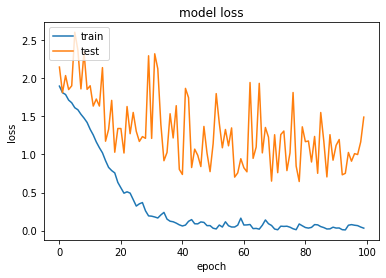

In [ ]:

# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.initializers import glorot_uniform
loaded_model = tf.keras.models.load_model("AudioAnalyser.h5",custom_objects={'GlorotUniform': glorot_uniform()})
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 83.06%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import io, base64
import librosa
import librosa.display
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
import scipy
from scipy.io import wavfile
import pandas as pd
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
def emotionOutput(path):
    """ Using the Audio Analyser model to predict the Emotions"""
    X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=3, sr=22050 * 2)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    df2 = feature
    df2 = pd.DataFrame(data=df2)
    df2 = df2.stack().to_frame().T
    df2expanded = np.expand_dims(df2, axis=2)
    loaded_model = load_model("AudioAnalyser.h5",custom_objects={'GlorotUniform': glorot_uniform()})
    pred = loaded_model.predict(df2expanded,batch_size=16,verbose=1)
    pred = pred.argmax(axis=1)
    predflatten = pred.astype(int).flatten()
    encoder = LabelEncoder()
    encoder.classes_ = np.load('encoder.npy',allow_pickle=True)
    livepredictions = (encoder.inverse_transform((predflatten)))
    return livepredictions[0]

In [ ]:
path = '/content/arctic-a0005_FKbdOXGr.wav'

In [ ]:
emotionOutput(path)

1/1 [==============================] - 0s 165ms/step


'male_angry'